In [50]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines

import seaborn as sns

In [51]:
# Loads college features into a dataframe
# Data: https://github.com/BaileyDalton007/USNEWS_College_Webscraping

COLLEGE_DATA_FILE = './data/college_data.csv'

df = pd.read_csv(COLLEGE_DATA_FILE, delimiter=',')

In [52]:
# Creates a symetrical colormap for heatmap visualizations
# From here: https://stackoverflow.com/questions/28439251/symmetric-colormap-matplotlib

def symmetrical_colormap(cmap_settings, new_name = None ):
    ''' This function take a colormap and create a new one, as the concatenation of itself by a symmetrical fold.
    '''
    # get the colormap
    cmap = plt.cm.get_cmap(*cmap_settings)
    if not new_name:
        new_name = "sym_"+cmap_settings[0]  # ex: 'sym_Blues'
    
    # this defined the roughness of the colormap, 128 fine
    n= 128 
    
    # get the list of color from colormap
    colors_r = cmap(np.linspace(0, 1, n))    # take the standard colormap # 'right-part'
    colors_l = colors_r[::-1]                # take the first list of color and flip the order # "left-part"

    # combine them and build a new colormap
    colors = np.vstack((colors_l, colors_r))
    mymap = mcolors.LinearSegmentedColormap.from_list(new_name, colors)

    return mymap

sym_c = symmetrical_colormap(cmap_settings=('YlGnBu', None))

# Centering the colormap so it is uniform across all heatmap plots
divnorm=mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

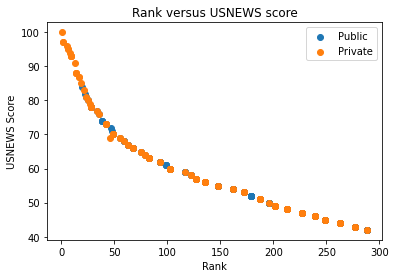

In [53]:

# After doing the correlation heatmap (the next figure), I saw that the correlation between rank and USNEWS score was not as high as it should be,
# considering that universities are ranked by their score.
# The figure (before fixing the data) showed a very direct correlation, but with a few outliers. After some investigation I saw that the webscraper
# was misreporting ranks for six or so schools, so I manually fixed that in the dataset. 

# Here were the outliers:
# DePaul University, University of St. Thomas (MN), University of the Incarnate Word
# Colorado School of Mines, University of Idaho, University of Memphis

# It seems that sometimes on the school's info page that USNEWS likes to put a ranking from a random category in the place where overall ranking
# usually is, which trips up the webscaper time to time.

fig, ax = plt.subplots()
fig.set_facecolor('white')

pub_df = df.loc[df['type'] == 'Public']
priv_df = df.loc[df['type'] == 'Private']

pub_plot = ax.scatter(pub_df['rank'], pub_df['usnews_score'], label='Public')
priv_plot = ax.scatter(priv_df['rank'], priv_df['usnews_score'], label='Private')

#for i, label in enumerate(pub_df['name']):
#    ax.annotate(label, (pub_df['rank'].iloc[i], pub_df['usnews_score'].iloc[i]))

ax.set_xlabel('Rank')
ax.set_ylabel('USNEWS Score')
ax.set_title('Rank versus USNEWS score')

plt.legend()

plt.show()

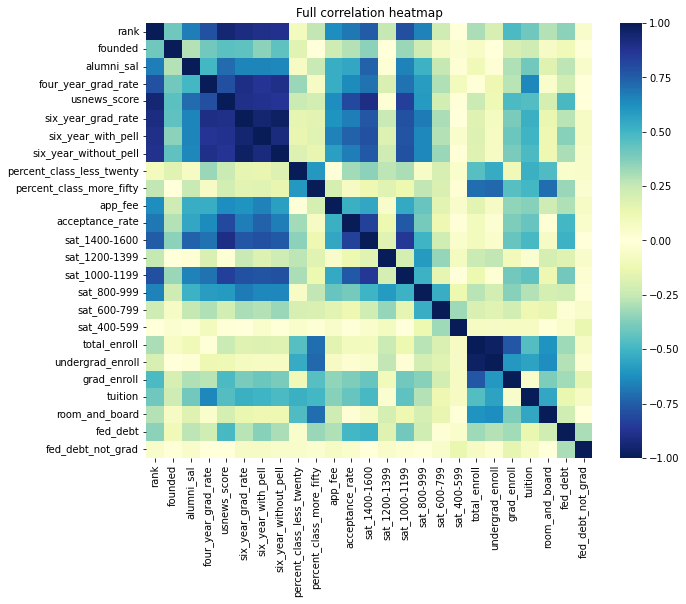

In [54]:
# A correlation heatmap showing how all the quantitative varibles affect
# one another. We are using a symmetrical colormap so that the
# variables with the biggest effect are darker regardless of direction
corr = df.corr()
fig, ax = plt.subplots()
fig.set_facecolor('white')

fig.set_size_inches((10, 8))

ax.set_title("Full correlation heatmap")

dataplot = sns.heatmap(corr, cmap=sym_c, norm=divnorm, yticklabels=True)
plt.show()

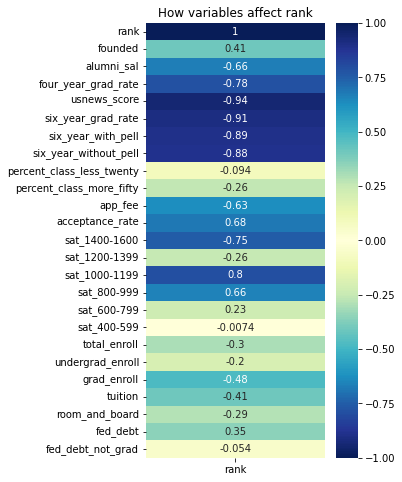

In [55]:
# A annotated correlation heatmap showing how each variable affects
# rank specifically

rank = df.corr()['rank']
fig, ax = plt.subplots()
fig.set_facecolor('white')

fig.set_size_inches((4, 8))

dataplot = sns.heatmap(rank.to_frame(), cmap=sym_c, annot=True, norm=divnorm, yticklabels=True)

ax.set_title("How variables affect rank")

plt.show()

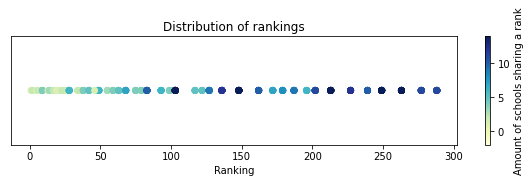

In [56]:
# Plot showing the spatial distrubition of rankings
# We can see that they get increasingly sparsed the farther back in the ranking we go
# Color is also determined with the amount of ties at a specific rank

fig, ax = plt.subplots()
fig.set_facecolor('white')
fig.set_size_inches((10, 2))

line_plot = ax.scatter(df['rank'], np.zeros_like(df['rank']), 
            c=df['rank'].value_counts()[df['rank']], cmap='YlGnBu', vmin=-2)

color_bar = fig.colorbar(line_plot)
color_bar.set_label('Amount of schools sharing a rank')
ax.set_title('Distribution of rankings')
ax.set_xlabel('Ranking')
ax.set_yticks([])

plt.show()

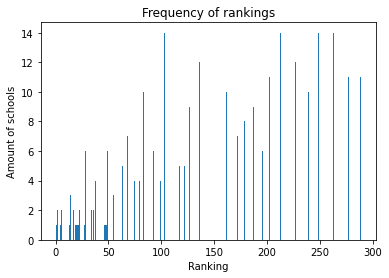

In [57]:
# A similar plots, but more clearly showing the difference in amount of schools
# at each rank
fig, ax = plt.subplots()
fig.set_facecolor('white')
bar_graph = ax.bar(df['rank'], df['rank'].value_counts()[df['rank']])

ax.set_title('Frequency of rankings')

ax.set_ylabel('Amount of schools')
ax.set_xlabel('Ranking')

plt.show()

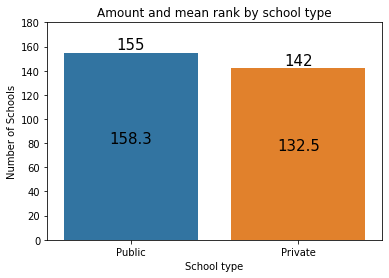

In [58]:
# Now we can compare public to private schools

fig, ax = plt.subplots()
fig.set_facecolor('white')

bars = ['Public', 'Private']
plot = sns.barplot(x=bars, y=df['type'].value_counts())

pub_mean_rank = df.loc[df['type'] == 'Public']['rank'].mean()
priv_mean_rank = df.loc[df['type'] == 'Private']['rank'].mean()

means = [pub_mean_rank, priv_mean_rank]

# Annotating the bars in the plot
# From: https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
for i, bar in enumerate(plot.patches):
    # Adds totals to top of bars
    plot.annotate(int(bar.get_height()),
                (bar.get_x() + bar.get_width() / 2,
                bar.get_height()), ha='center', va='center',
                size=15, xytext=(0, 8),
                textcoords='offset points')

    # Adds averages to middle of bars
    plot.annotate(format(means[i], '.1f'),
                (bar.get_x() + bar.get_width() / 2,
                bar.get_height() / 2), ha='center', va='center',
                size=15, xytext=(0, 8),
                textcoords='offset points')

plot.set_ylim(0, 180)
plot.set_xlabel('School type')
plot.set_ylabel('Number of Schools')
plot.set_title('Amount and mean rank by school type')

plt.show()

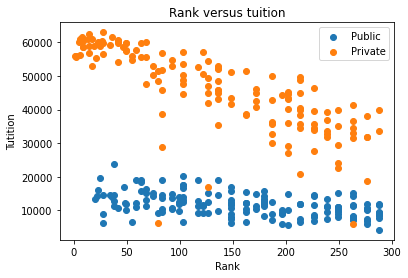

In [59]:
# Here we see a very interesting trend. Of course there are two clear lines depending
# upon the type of school. We can also see that the higher the price, the higher the rank,
# especially for private schools

fig, ax = plt.subplots()
fig.set_facecolor('white')

pub_df = df.loc[df['type'] == 'Public']
priv_df = df.loc[df['type'] == 'Private']

pub_plot = ax.scatter(pub_df['rank'], pub_df['tuition'], label='Public')
priv_plot = ax.scatter(priv_df['rank'], priv_df['tuition'], label='Private')

ax.set_xlabel('Rank')
ax.set_ylabel('Tutition')
ax.set_title('Rank versus tuition')

plt.legend()

plt.show()

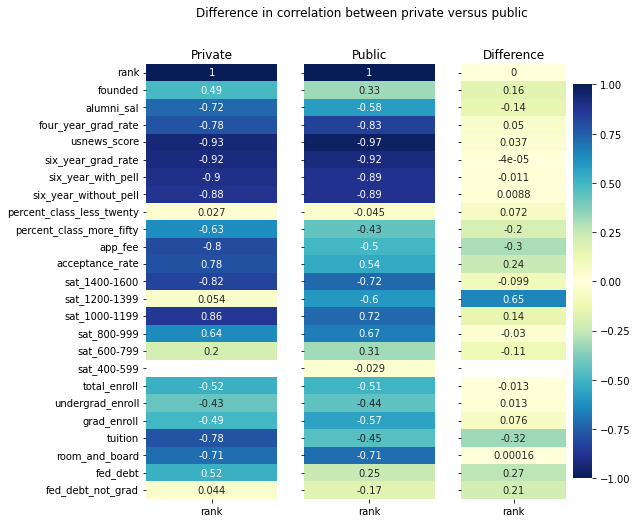

In [60]:
# He we can compare the difference between the affect that each variable has on private / public schools respectively
priv_rank = priv_df.corr()['rank'].to_frame()
pub_rank = pub_df.corr()['rank'].to_frame()

diff_df = pd.DataFrame()

for col in priv_rank.columns:
    diff_df[col] = priv_rank[col] - pub_rank[col]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
fig.set_facecolor('white')
fig.set_size_inches((8, 8))


priv_dataplot = sns.heatmap(priv_rank, cmap=sym_c, annot=True, yticklabels=True, cbar=False, norm=divnorm, ax=ax1)
pub_dataplot = sns.heatmap(pub_rank, cmap=sym_c, annot=True, yticklabels=True, cbar=False, norm=divnorm, ax=ax2)

diff_dataplot = sns.heatmap(diff_df, cmap=sym_c, annot=True, yticklabels=True, norm=divnorm, ax=ax3)

ax1.set_title('Private')
ax2.set_title('Public')
ax3.set_title('Difference')

fig.suptitle('Difference in correlation between private versus public')

plt.show()

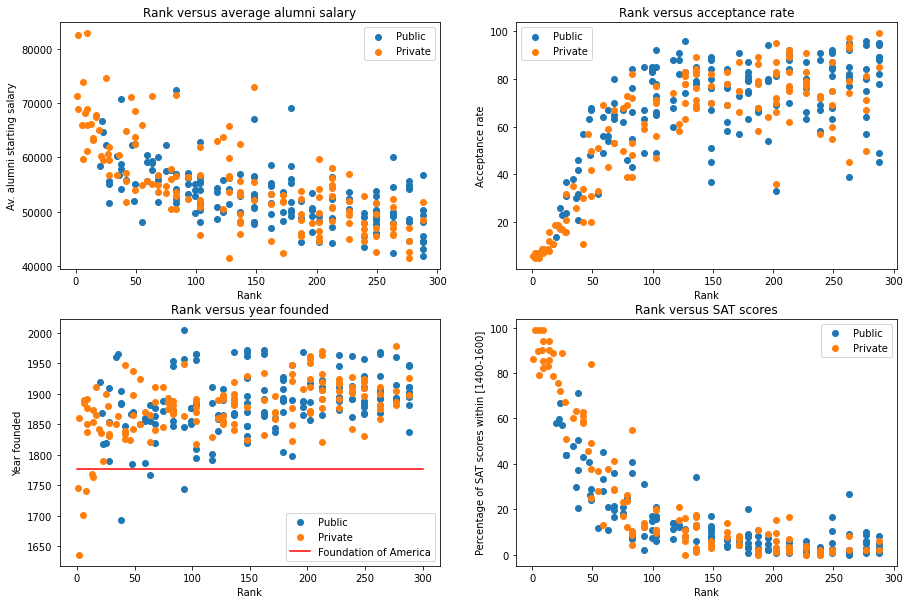

In [61]:
# Here are a few graphs that are all fairly linear and frankly not terribly interesting
# so I combined them into one figure

fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(2, 2)
fig.set_facecolor('white')
fig.set_size_inches((15, 10))

pub_df = df.loc[df['type'] == 'Public']
priv_df = df.loc[df['type'] == 'Private']

# He we see what should be expected, the higher ranked college you attend does
# often impact your salary (or the other way around), and there seems to be no
# grouping between types of universities

pub_plot = ax1.scatter(pub_df['rank'], pub_df['alumni_sal'], label='Public')
priv_plot = ax1.scatter(priv_df['rank'], priv_df['alumni_sal'], label='Private')

ax1.set_xlabel('Rank')
ax1.set_ylabel('Av. alumni starting salary')
ax1.set_title('Rank versus average alumni salary')

ax1.legend()


# Another expected correlation, higher ranks mean lower acceptance rates
pub_plot = ax2.scatter(pub_df['rank'], pub_df['acceptance_rate'], label='Public')
priv_plot = ax2.scatter(priv_df['rank'], priv_df['acceptance_rate'], label='Private')

ax2.set_xlabel('Rank')
ax2.set_ylabel('Acceptance rate')
ax2.set_title('Rank versus acceptance rate')
ax2.legend()


# Not much of a correlation, but it is interesting to see that many of the very
# prestigious schools were founded prior to the country that they reside in 

pub_plot = ax3.scatter(pub_df['rank'], pub_df['founded'], label='Public')
priv_plot = ax3.scatter(priv_df['rank'], priv_df['founded'], label='Private')

line = mlines.Line2D([0, 300], [1776, 1776], color='red')
ax3.add_line(line)

ax3.set_xlabel('Rank')
ax3.set_ylabel('Year founded')
ax3.set_title('Rank versus year founded')

ax3.legend(['Public','Private', 'Foundation of America'])

# Here we see another expected correlation, but I do think it is interesting
# how sharply the curve drops past the top 20 or so schools
pub_plot = ax4.scatter(pub_df['rank'], pub_df['sat_1400-1600'], label='Public')
priv_plot = ax4.scatter(priv_df['rank'], priv_df['sat_1400-1600'], label='Private')

ax4.set_xlabel('Rank')
ax4.set_ylabel('Percentage of SAT scores within [1400-1600]')
ax4.set_title('Rank versus SAT scores')

ax4.legend()

plt.show()



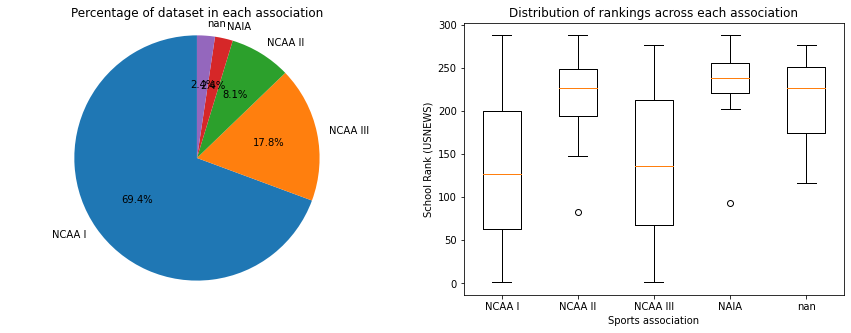

In [62]:
# Here is a pie chart showing the distrubition of collegiate sports associations that the ranked universities
# belong to

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_facecolor('white')
fig.set_size_inches((15, 5))


sports_df = df['sport_assoc'].value_counts(dropna=False)

ax1.pie(sports_df, labels=sports_df.index, autopct='%1.1f%%', startangle=90)
ax1.set_title('Percentage of dataset in each association')
ax1.axis('equal')


# Here is a box plot showing the distribution of ranks per sport association
# Ranks as in USNEWS rankings, not athletic rankings
rank_arrs = []

labels = sports_df.index.values

# Fixes ordering-just makes NCAA II before NCAA III
tmp = labels[2]
labels[2] = labels[1]
labels[1] = tmp

for column in sports_df.index:
    rank_arrs.append([])

for _, row in df.iterrows():
    rank = row['rank']
    
    s = row['sport_assoc']
    index = np.where(labels == s)

    if len(index[0]) == 0:
        index = 4
    else:
        index = index[0][0]

    rank_arrs[index].append(rank)

# Plotting
ax2.boxplot(rank_arrs, labels=labels)

ax2.set_title('Distribution of rankings across each association')
ax2.set_xlabel('Sports association')
ax2.set_ylabel('School Rank (USNEWS)')

plt.show()

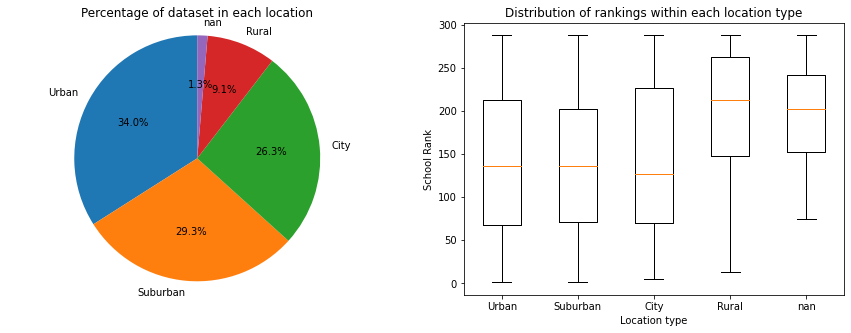

In [63]:
# Here is a pie chart showing the distrubition of location types of the ranked universities

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_facecolor('white')
fig.set_size_inches((15, 5))


loc_df = df['location_type'].value_counts(dropna=False)

ax1.pie(loc_df, labels=loc_df.index, autopct='%1.1f%%', startangle=90)
ax1.set_title('Percentage of dataset in each location')
ax1.axis('equal')


# Here is a box plot showing the distribution of ranks per location type
rank_arrs = []

labels = loc_df.index.values

for column in loc_df.index:
    rank_arrs.append([])

for _, row in df.iterrows():
    rank = row['rank']
    
    s = row['location_type']
    index = np.where(labels == s)

    if len(index[0]) == 0:
        index = 4
    else:
        index = index[0][0]

    rank_arrs[index].append(rank)

# Plotting
ax2.boxplot(rank_arrs, labels=labels)

ax2.set_title('Distribution of rankings within each location type')
ax2.set_xlabel('Location type')
ax2.set_ylabel('School Rank')

plt.show()

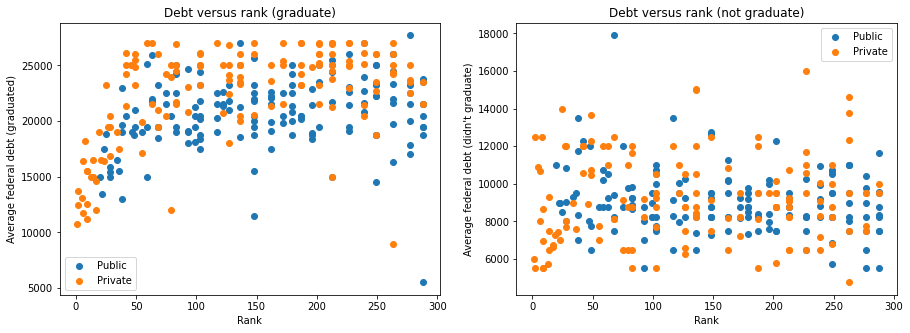

In [64]:
# Here showing the average federal debt per school for both graduated and non-graduated students
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_facecolor('white')
fig.set_size_inches((15, 5))

pub_df = df.loc[df['type'] == 'Public']
priv_df = df.loc[df['type'] == 'Private']

pub_plot = ax1.scatter(pub_df['rank'], pub_df['fed_debt'], label='Public')
priv_plot = ax1.scatter(priv_df['rank'], priv_df['fed_debt'], label='Private')

ax1.set_xlabel('Rank')
ax1.set_ylabel('Average federal debt (graduated)')
ax1.set_title('Debt versus rank (graduate)')

# Now for students who didn't graduate
pub_plot = ax2.scatter(pub_df['rank'], pub_df['fed_debt_not_grad'], label='Public')
priv_plot = ax2.scatter(priv_df['rank'], priv_df['fed_debt_not_grad'], label='Private')

ax2.set_xlabel('Rank')
ax2.set_ylabel('Average federal debt (didn\'t graduate)')
ax2.set_title('Debt versus rank (not graduate)')

ax1.legend()
ax2.legend()

plt.show()

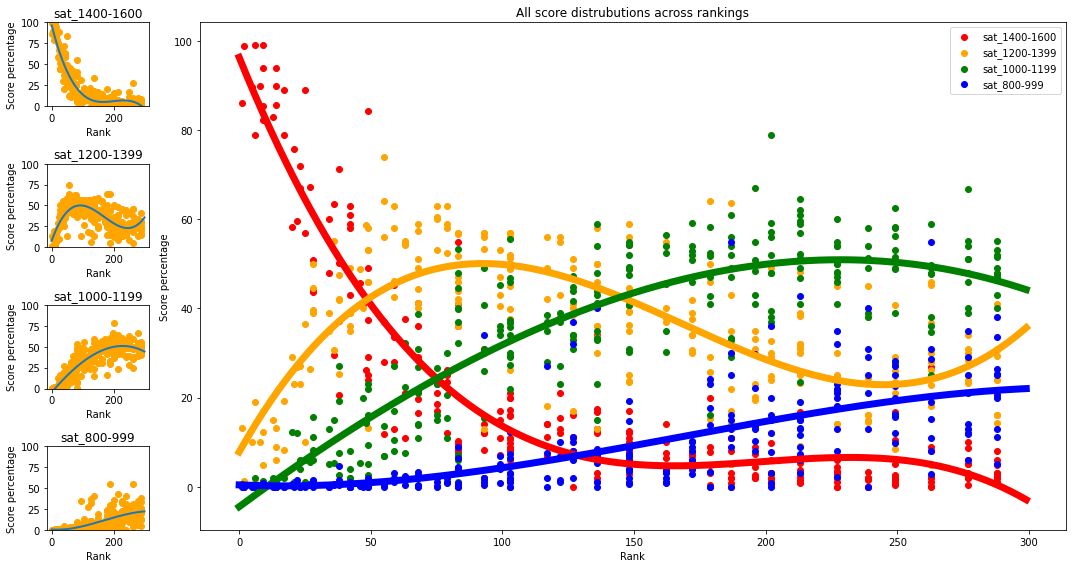

In [65]:
# Full SAT score plot (the big one)
# Dropped ranges 600-799 and 599-400 as all the percentages were basically zero
fig = plt.figure()
fig.set_facecolor('white')
fig.set_figwidth(15)
fig.set_figheight(8)

ax1 = plt.subplot2grid(shape=(4, 7), loc=(0, 0))
ax2 = plt.subplot2grid(shape=(4, 7), loc=(1, 0))
ax3 = plt.subplot2grid(shape=(4, 7), loc=(2, 0))
ax4 = plt.subplot2grid(shape=(4, 7), loc=(3, 0))

ax5 = plt.subplot2grid(shape=(4, 7), loc=(0, 1), rowspan=4, colspan=9)

ranges_arr = ['sat_1400-1600', 'sat_1200-1399', 'sat_1000-1199', 'sat_800-999']

# Matplotlib axis for each respective SAT range's plot
ranges_axes = [ax1, ax2, ax3, ax4]

lines = []
test_range = np.array(range(300)).reshape(-1, 1)

for column, ax in zip(ranges_arr, ranges_axes):

    clean_df = df[df[column].notna()]

    # I did have it select a degree for each line, but a 3rd order polynomial worked well for all
    # of the ranges, so just removed that functionality
    poly = PolynomialFeatures(degree=3, include_bias=False)
    poly_features_train = poly.fit_transform(clean_df[['rank']])

    reg = LinearRegression().fit(poly_features_train, clean_df[[column]])


    poly_features_test = poly.fit_transform(test_range)

    y_pred = reg.predict(poly_features_test)

    ax.scatter(df['rank'], df[column], c='orange')
    ax.plot(test_range, y_pred.reshape(-1, 1), linewidth=2)

    # Save lines to use in the big graph
    lines.append(y_pred.reshape(-1, 1))

    ax.set_ylim(0, 100)
    ax.set_ylabel('Score percentage')
    ax.set_xlabel('Rank')
    ax.set_title(column)

colors = ['red', 'orange', 'green', 'blue']

for column, color in zip(ranges_arr, colors):
    ax5.scatter(df['rank'], df[column], c=color)

for line, color in zip(lines, colors):
    ax5.plot(test_range, line, linewidth=7, c=color)

ax5.legend(ranges_arr)
ax5.set_title('All score distrubutions across rankings')
ax5.set_xlabel('Rank')
ax5.set_ylabel('Score percentage')

fig.tight_layout()
plt.show()

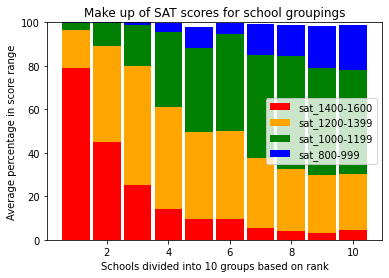

In [66]:
# Here is a plot showing average SAT score percentages over buckets of universities
# This should make trends a bit more clear, since the previous graph, despite being cool, is somewhat hard to comprehend

fig, ax = plt.subplots()
fig.set_facecolor('white')
ax.set_ylim(0, 100)

# Set to the desired amount 
NUM_BUCKETS = 10

ranges_arr = ['sat_1400-1600', 'sat_1200-1399', 'sat_1000-1199', 'sat_800-999']
colors = ['red', 'orange', 'green', 'blue']

last = np.array([0 for _ in range(NUM_BUCKETS)])

for i, column in enumerate(ranges_arr):
    clean_df = df[df[column].notna()]

    organized_data = [[]]

    averages = []
    curr_bucket = 0

    bucket_size = len(clean_df.index) // (NUM_BUCKETS)
    
    # Seperate percentiles into each bucket
    for _, row in clean_df.iterrows():
        
        if len(organized_data[curr_bucket]) >= bucket_size:
            organized_data.append([row[column]])
            curr_bucket = curr_bucket + 1
        else:
            organized_data[curr_bucket].append(row[column])

    # Technically leaves a few at the end out, but those aren't very well ranked anyway
    organized_data = organized_data[:NUM_BUCKETS]
    
    # Get average of each bucket
    for bucket in organized_data:
        average = float(format((sum(bucket) / len(bucket)), '.1f'))
        averages.append(average)

    ax.bar(range(1, NUM_BUCKETS + 1), averages, 0.9, bottom=last, color=colors[i], label=column)
    last = np.array(averages) + np.array(last)

ax.set_title('Make up of SAT scores for school groupings')
ax.set_ylabel('Average percentage in score range')
ax.set_xlabel(f'Schools divided into {NUM_BUCKETS} groups based on rank')

ax.legend()
plt.show()

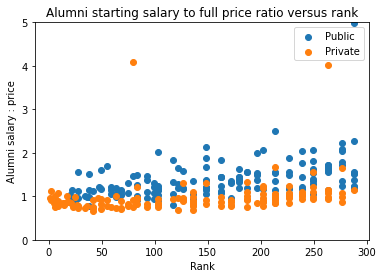

In [67]:
# Here we are comparing the starting salary to full price ratio
# That first outlier is Brigham Young University--Provo with a tuition of $6,120
fig, ax = plt.subplots()
fig.set_facecolor('white')

pub_df = df.loc[df['type'] == 'Public']
priv_df = df.loc[df['type'] == 'Private']

pub_ratio = pub_df['alumni_sal'] / (pub_df['tuition'] + pub_df['room_and_board'])
priv_ratio = priv_df['alumni_sal'] / (priv_df['tuition'] + priv_df['room_and_board'])

ax.scatter(pub_df['rank'], pub_ratio)
ax.scatter(priv_df['rank'], priv_ratio)

#for i, label in enumerate(priv_df['name']):
#    ax.annotate(label, (priv_df['rank'].iloc[i], priv_ratio.iloc[i]))


ax.set_title('Alumni starting salary to full price ratio versus rank')
ax.set_ylabel('Alumni salary : price')
ax.set_xlabel('Rank')
ax.set_ylim(0, 5.0)
ax.legend(['Public', 'Private'])

plt.show()

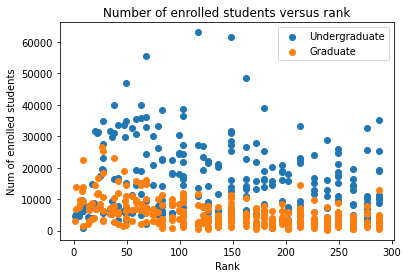

In [68]:
# Comparing enrollment numbers
# Nothing much interesting here
fig, ax = plt.subplots()
fig.set_facecolor('white')

ax.scatter(df['rank'], df['undergrad_enroll'])
ax.scatter(df['rank'], df['grad_enroll'])

# Show total enrollment
#ax.scatter(df['rank'], df['grad_enroll'] + df['undergrad_enroll'])

ax.legend(['Undergraduate', 'Graduate'])
ax.set_xlabel('Rank')
ax.set_ylabel('Num of enrolled students')
ax.set_title('Number of enrolled students versus rank')
plt.show()